In [9]:
import kagglehub
import os

# Download dataset
path = kagglehub.dataset_download("farzadnekouei/trash-type-image-dataset")
print("Root path:", path)

# Correct path to actual dataset folder
dataset_path = os.path.join(path, "TrashType_Image_Dataset")
print("Dataset path:", dataset_path)

# Verify folder exists
if not os.path.exists(dataset_path):
    print("ERROR: Dataset folder not found at", dataset_path)
    print("Contents of root:", os.listdir(path))
else:
    classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

    for cls in classes:
        class_folder = os.path.join(dataset_path, cls)

        if os.path.exists(class_folder):
            count = len(os.listdir(class_folder))
            print(f"{cls}: {count} images")
        else:
            print(f"WARNING: Class folder not found - {class_folder}")


Root path: /kaggle/input/trash-type-image-dataset
Dataset path: /kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset
cardboard: 403 images
glass: 501 images
metal: 410 images
paper: 594 images
plastic: 482 images
trash: 137 images


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,                # Normalization
    rotation_range=20,             # Data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15          # Split for validation
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),        # Resizing
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 2150 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze base model layers for initial training
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10  # You can adjust the number of epochs
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5584 - loss: 1.1593

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.5599 - loss: 1.1555 - val_accuracy: 0.7719 - val_loss: 0.6507
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.7995 - loss: 0.5371 - val_accuracy: 0.7321 - val_loss: 0.7257
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.8214 - loss: 0.5040 - val_accuracy: 0.7454 - val_loss: 0.6641
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.8585 - loss: 0.3960 - val_accuracy: 0.7825 - val_loss: 0.6065
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.8690 - loss: 0.3423 - val_accuracy: 0.7931 - val_loss: 0.6529
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.8854 - loss: 0.3113 - val_accuracy: 0.7798 - val_loss: 0.6742
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9032 - loss: 0.2781 - val_accuracy: 0.7719 - val_loss: 0.6696
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.8922 - loss: 0.3045 - val_accuracy: 0.7905 - val_loss: 0.

In [14]:
# Evaluate performance
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8047 - loss: 0.6394
Validation Loss: 0.6727
Validation Accuracy: 0.8011


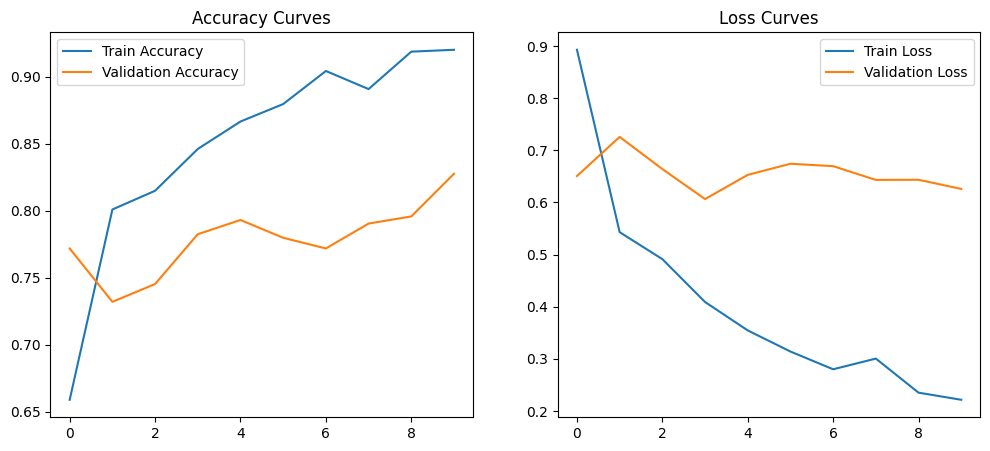

Final Training Accuracy: 0.9200
Final Validation Accuracy: 0.8276


In [17]:
import matplotlib.pyplot as plt

# Extract training metrics
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

# Print final metrics
print(f"Final Training Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step
              precision    recall  f1-score   support

   cardboard       0.12      0.13      0.13        60
       glass       0.22      0.19      0.20        75
       metal       0.13      0.15      0.14        61
       paper       0.23      0.25      0.24        89
     plastic       0.17      0.14      0.15        72
       trash       0.05      0.05      0.05        20

    accuracy                           0.17       377
   macro avg       0.15      0.15      0.15       377
weighted avg       0.17      0.17      0.17       377



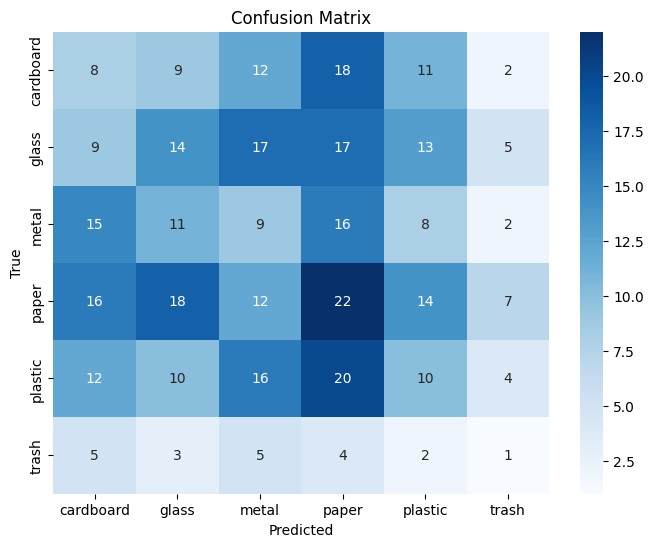

In [15]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels and predictions
val_generator.reset()
Y_true = val_generator.classes
Y_pred = model.predict(val_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)
class_labels = list(val_generator.class_indices.keys())

# Classification report
print(classification_report(Y_true, Y_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
